# Modelling of a Shack-Hartmann Sensor for eye aberration evaluation - updated example

This example is an updated version of the knowledge base example [Modelling of a Shack-Hartmann Sensor for eye aberration evaluation](https://support.zemax.com/hc/en-us/articles/4406838460819-Modelling-of-a-Shack-Hartmann-Sensor-for-eye-aberration-evaluation). In specific, it uses an improved gradient for the reversed crystalline lens. It uses `ZOSPy` to control the API. 

### Included functionalities

* _Sequential mode_:
  - System design:
    - Usage of `zospy.functions.lde.surface_change_type` to change the surface type, including the use of user defined surfaces
    - Usage of `zospy.functions.lde.surface_change_aperturetype` to change the aperture type of a specific surface.
    - Usage of `zospy.solvers.material_model` to change the material of a surface.
    - Usage of the `PhysicalOpticsData` attribute of a surface to alter specific physical optics settings
    - Usage of the `CoatingData` attribute of a surface to alter specific coating settings
    - Usage of `oss.MCE` to access the multiple configurations editor and specify various configurations of the same model.
    - Usage of `oss.SystemData` to adjust specific system settings 
  - Analysis:
    - Usage of `zospy.analyses.wavefront.ZernikeStandardCoefficients` to perform a Zernike standard coefficients analysis.
    - Usage of `zospy.analyses.wavefront.WavefrontMap` to perform a wavefront map analysis.  
    - Usage of `zospy.analyses.extendedscene.GeometricImageAnalysis` to perform a geometric image analysis.
    - Usage of `zospy.analyses.physicaloptics.create_beam_parameter_dict` to obtain and alter the default beam parameters for a specific physical optics propagation beam type.
    - Usage of `zospy.analyses.physicaloptics.PhysicalOpticsPropagation` to perform a physical optics propagation analysis.

### Warranty and liability

The examples are provided 'as is'. There is no warranty and rights cannot be derived from them, as is also stated in the general license of this repository.

## Import dependencies

In [1]:
from warnings import warn

import matplotlib.pyplot as plt
import pandas as pd

import zospy as zp
from zospy.functions.lde import surface_change_aperturetype, surface_change_type
from zospy.solvers import material_model

## Initialize OpticStudio

Establishing a connection with OpticStudio through the `ZOSPy` library.

In this example we connect with OpticStudio in extension mode. 

In [2]:
zos = zp.ZOS()
oss = zos.connect("extension")

A new system is directly created and it is ensured that it is in sequential mode.

In [3]:
oss.new()
oss.make_sequential()

True

## Create eye

In this section, we create the reversed eye model. Note that the gradient parameters passed to *lens back* and *lens front* are different from the parameters in the knowledgebase example. 

To keep track of the amount of surfaces we have implemented, we utilize a constant called `n_surf`.

In [4]:
n_surf = 0  # Make sure we start at surface 0.

# Object
s_object = oss.LDE.GetSurfaceAt(n_surf)
n_surf += 1
s_object.Thickness = 0

# Retina
s_eye_retina = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_eye_retina.Comment = "Eye Retina Vitreous"
s_eye_retina.Radius = 12.0
s_eye_retina.Thickness = 17.928551
material_model(s_eye_retina.MaterialCell, refractive_index=1.336, abbe_number=50.23)
s_eye_retina.Conic = 0.0
s_eye_retina.SemiDiameter = 12

# Lens back
s_eye_lens_back = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
surface_change_type(s_eye_lens_back, zp.constants.Editors.LDE.SurfaceType.Gradient3)
s_eye_lens_back.Comment = "Eye Lens Back"
s_eye_lens_back.Radius = 8.1
s_eye_lens_back.Thickness = 2.430
s_eye_lens_back.Conic = 0.960
s_eye_lens_back.SemiDiameter = 5
s_eye_lens_back.SurfaceData.DeltaT = 1.0
s_eye_lens_back.SurfaceData.n0 = 1.36799814
s_eye_lens_back.SurfaceData.Nr2 = -1.978e-03
s_eye_lens_back.SurfaceData.Nz1 = 0.03210030
s_eye_lens_back.SurfaceData.Nz2 = -6.605e-03

s_eye_lens_back.PhysicalOpticsData.UseRaysToPropagateToNextSurface = True

# Lens front
s_eye_lens_front = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
surface_change_type(s_eye_lens_front, zp.constants.Editors.LDE.SurfaceType.Gradient3)
s_eye_lens_front.Comment = "Eye Lens Front"
s_eye_lens_front.Radius = 0.0
s_eye_lens_front.Thickness = 1.590
s_eye_lens_front.Conic = 0.0
s_eye_lens_front.SemiDiameter = 5
s_eye_lens_front.SurfaceData.DeltaT = 1.0
s_eye_lens_front.SurfaceData.n0 = 1.40699963
s_eye_lens_front.SurfaceData.Nr2 = -1.978e-03
s_eye_lens_front.SurfaceData.Nz1 = 8.6000e-07
s_eye_lens_front.SurfaceData.Nz2 = -0.015427

s_eye_lens_front.PhysicalOpticsData.UseRaysToPropagateToNextSurface = True

# Posterior chamber
s_eye_posterior_chamber = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_eye_posterior_chamber.Comment = "Posterior chamber"
s_eye_posterior_chamber.Radius = -12.40
s_eye_posterior_chamber.Thickness = 0.0
material_model(
    s_eye_posterior_chamber.MaterialCell, refractive_index=1.336, abbe_number=50.23
)
s_eye_posterior_chamber.Conic = 0.0
s_eye_posterior_chamber.SemiDiameter = 5.0

s_eye_posterior_chamber.PhysicalOpticsData.UseRaysToPropagateToNextSurface = True

# Pupil
s_eye_pupil = oss.LDE.GetSurfaceAt(n_surf)
n_surf += 1
s_eye_pupil.Comment = "Pupil"
s_eye_pupil.Radius = 0.0  # Check
s_eye_pupil.Thickness = 3.160  # Check for oblique rays, if possible remove next surface
material_model(s_eye_pupil.MaterialCell, refractive_index=1.336, abbe_number=50.23)
s_eye_pupil.Conic = 0.0
s_eye_pupil.SemiDiameter = 2.0

surface_change_aperturetype(
    s_eye_pupil, zp.constants.Editors.LDE.SurfaceApertureTypes.FloatingAperture
)

# Cornea back
s_eye_cornea_back = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_eye_cornea_back.Comment = "Cornea Back"
s_eye_cornea_back.Radius = -6.40
s_eye_cornea_back.Thickness = 0.550
material_model(
    s_eye_cornea_back.MaterialCell, refractive_index=1.376, abbe_number=50.23
)
s_eye_cornea_back.Conic = -0.60
s_eye_cornea_back.SemiDiameter = 5.0

# Cornea front
s_eye_cornea_front = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_eye_cornea_front.Comment = "Cornea Front"
s_eye_cornea_front.Radius = -7.770
s_eye_cornea_front.Thickness = 0.0
s_eye_cornea_front.Conic = -0.18
s_eye_cornea_front.SemiDiameter = 5.0

## MCE

Now that we created a reversed eye model, we use the multi configuration editor to ensure that we can switch between several variants of the same system and analyze them.

In [5]:
oss.MCE.ShowEditor()

# Insert extra configurations
oss.MCE.InsertConfiguration(2, False)
oss.MCE.InsertConfiguration(3, False)

True

The first two rows in the MCE are of the 'IGNM' operand type, allowing you to ignore a (range of) surface(s) in a specific configuration. While these two rows are not used in the knowledgebase example, we keep them for consistency.

In [6]:
mce_1 = oss.MCE.GetOperandAt(1)
mce_1.ChangeType(zp.constants.Editors.MCE.MultiConfigOperandType.IGNM)
mce_1.GetOperandCell(1).IntegerValue = 0
mce_1.GetOperandCell(2).IntegerValue = 0
mce_1.GetOperandCell(3).IntegerValue = 0
mce_1.Param1 = s_eye_retina.SurfaceNumber - 1  # minus 1 as param 1 omits object in list
mce_1.Param2 = s_eye_posterior_chamber.SurfaceNumber

mce_2 = oss.MCE.InsertNewOperandAt(2)
mce_2.ChangeType(zp.constants.Editors.MCE.MultiConfigOperandType.IGNM)
mce_2.GetOperandCell(1).IntegerValue = 0
mce_2.GetOperandCell(2).IntegerValue = 0
mce_2.GetOperandCell(3).IntegerValue = 0
# mce_2 gets updated later as it requires the HS sensor

The third row of the MCE uses the 'MOFF' operand, which can be used for comments. It is used to describe the three variations of the eye model (Normal, Myopic, Hypermetropic).

In [7]:
mce_3 = oss.MCE.InsertNewOperandAt(3)
mce_3.ChangeType(zp.constants.Editors.MCE.MultiConfigOperandType.MOFF)
mce_3.GetOperandCell(1).Value = "Normal"
mce_3.GetOperandCell(2).Value = "Myopia"
mce_3.GetOperandCell(3).Value = "Hyperopia"

The fourth row of the MCE uses the 'THIC' operand, which can be used to change the thickness of a specific surface. It is used to variate the length of the vitreous between the three states of the eye model (Normal, Myopic, Hypermetropic).

In [8]:
mce_4 = oss.MCE.InsertNewOperandAt(4)
mce_4.ChangeType(zp.constants.Editors.MCE.MultiConfigOperandType.THIC)
mce_4.Param1 = s_eye_retina.SurfaceNumber
mce_4.GetOperandCell(1).DoubleValue = 17.928551048789998
mce_4.GetOperandCell(2).DoubleValue = 25.000  # 27.000
mce_4.GetOperandCell(3).DoubleValue = 11.000  # 13.000

## System settings

Now we adjust some system settings to ensure we have the same settings as the knowledge base example.

In [9]:
# Aperture
oss.SystemData.Aperture.ApertureType = zp.constants.SystemData.ZemaxApertureType = (
    zp.constants.SystemData.ZemaxApertureType.FloatByStopSize
)
oss.SystemData.Aperture.ApodizationType = (
    zp.constants.SystemData.ZemaxApodizationType.Gaussian
)
oss.SystemData.Aperture.ApodizationFactor = 1.0

oss.SystemData.Aperture.AFocalImageSpace = (
    False  # True <- file of example does not have afocal image space
)

# Rayaiming
oss.SystemData.RayAiming.RayAiming = zp.constants.SystemData.RayAimingMethod.Paraxial

# Advanced
oss.SystemData.Advanced.ReferenceOPD = (
    zp.constants.SystemData.ReferenceOPDSetting.Absolute
)
oss.SystemData.Advanced.HuygensIntegralMethod = (
    zp.constants.SystemData.HuygensIntegralSettings.Planar
)

# Wavelength
wl1 = oss.SystemData.Wavelengths.GetWavelength(1)
wl1.Wavelength = 0.830

## Telescopes

In this section, we define the two telescopes between the eye and the Shack-Hartmann sensor.

### Telescope 1

Telescope 1 consists of 6 surfaces, some with a different surface aperture type or coating.

In [10]:
# Telescope 1 - surface 1
s_tel1_1 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel1_1.Radius = 0.0
s_tel1_1.Thickness = 95.200
s_tel1_1.SemiDiameter = 10

# Telescope 1 - surface 2
s_tel1_2 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel1_2.Radius = 102.5
s_tel1_2.Thickness = 5.0
s_tel1_2.Material = "N-BK7"
s_tel1_2.SemiDiameter = 14.5
s_tel1_2.ChipZone = 0.5

surface_change_aperturetype(
    s_tel1_2,
    zp.constants.Editors.LDE.SurfaceApertureTypes.CircularAperture,
    maximum_radius=14.5,
)

s_tel1_2.CoatingData.Coating = "THORB"

# Telescope 1 - surface 3
s_tel1_3 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel1_3.Radius = -102.5
s_tel1_3.Thickness = 199.0
s_tel1_3.SemiDiameter = 14.5
s_tel1_3.ChipZone = 0.5

s_tel1_3.CoatingData.Coating = "THORB"

# Telescope 1 - surface 4
s_tel1_4 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel1_4.Radius = 102.5
s_tel1_4.Thickness = 5.0
s_tel1_4.Material = "N-BK7"
s_tel1_4.SemiDiameter = 14.5
s_tel1_4.ChipZone = 0.5

surface_change_aperturetype(
    s_tel1_4,
    zp.constants.Editors.LDE.SurfaceApertureTypes.CircularAperture,
    maximum_radius=14.5,
)

s_tel1_4.CoatingData.Coating = "THORB"

# Telescope 1 - surface 5
s_tel1_5 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel1_5.Radius = -102.5
s_tel1_5.Thickness = 99.5
s_tel1_5.SemiDiameter = 14.5
s_tel1_5.ChipZone = 0.5

s_tel1_5.CoatingData.Coating = "THORB"

# Telescope 1 - surface 6
s_tel1_6 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel1_6.Comment = "ph"
s_tel1_6.Radius = 0.0
s_tel1_6.Thickness = 0.0
s_tel1_6.SemiDiameter = 6.0

surface_change_aperturetype(
    s_tel1_6,
    zp.constants.Editors.LDE.SurfaceApertureTypes.CircularObscuration,
    minimum_radius=6,
    maximum_radius=12,
)

We also make surface 6 of telescope 1 the global coordinate reference.

In [11]:
s_tel1_6.TypeData.IsGlobalCoordinateReference = True

### Telescope 2

Telescope 2 consists of 9 surfaces, some with a different surface aperture type or coating.

In [12]:
# Telescope 2 - surface 1
s_tel2_1 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_1.Radius = 0.0
s_tel2_1.Thickness = 99.5
s_tel2_1.SemiDiameter = 6.0
s_tel2_1.MechanicalSemiDiameter = 12.0

# Telescope 2 - surface 2
s_tel2_2 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_2.Radius = 102.5
s_tel2_2.Thickness = 5.0
s_tel2_2.Material = "N-BK7"
s_tel2_2.SemiDiameter = 14.5
s_tel2_2.ChipZone = 0.5

surface_change_aperturetype(
    s_tel2_2,
    zp.constants.Editors.LDE.SurfaceApertureTypes.CircularAperture,
    maximum_radius=14.5,
)

s_tel2_2.CoatingData.Coating = "THORB"

# Telescope 2 - surface 3
s_tel2_3 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_3.Radius = -102.5
s_tel2_3.Thickness = 99.5
s_tel2_3.SemiDiameter = 14.5
s_tel2_3.ChipZone = 0.5

s_tel2_3.CoatingData.Coating = "THORB"

# Telescope 2 - surface 4
s_tel2_4 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_4.Comment = "ph"
s_tel2_4.Radius = 0.0
s_tel2_4.Thickness = 0.0
s_tel2_4.SemiDiameter = 3.0

surface_change_aperturetype(
    s_tel2_4,
    zp.constants.Editors.LDE.SurfaceApertureTypes.CircularObscuration,
    minimum_radius=20,
    maximum_radius=20,
)

# Telescope 2 - surface 5
s_tel2_5 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_5.Radius = 0.0
s_tel2_5.Thickness = 99.5
s_tel2_5.SemiDiameter = 14.5

# Telescope 2 - surface 6
s_tel2_6 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_6.Radius = 102.5
s_tel2_6.Thickness = 5.0
s_tel2_6.Material = "N-BK7"
s_tel2_6.SemiDiameter = 14.5
s_tel2_6.ChipZone = 0.5

surface_change_aperturetype(
    s_tel2_6,
    zp.constants.Editors.LDE.SurfaceApertureTypes.CircularAperture,
    maximum_radius=14.5,
)

s_tel2_6.CoatingData.Coating = "THORB"

# Telescope 2 - surface 7
s_tel2_7 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_7.Radius = -102.5
s_tel2_7.Thickness = 0.0
s_tel2_7.SemiDiameter = 14.5
s_tel2_7.ChipZone = 0.5

s_tel2_7.CoatingData.Coating = "THORB"

# Telescope 2 - surface 8
s_tel2_8 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_8.Radius = 0.0
s_tel2_8.Thickness = 99.5
s_tel2_8.SemiDiameter = 6

# Telescope 2 - surface 9
s_tel2_9 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_tel2_9.Radius = 0.0
s_tel2_9.Thickness = 0.0

## Shack-Hartmann Sensor

Now, we create the Shack-Hartmann Sensor. It consists of three surfaces. Note that on surface 1, we make sure `ResampleAfterRefraction` is on and configured. We also use a user defined surface with specific settings for surface 2.

In [13]:
# Shack-Hartmann sensor - surface 1
s_hs_1 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
s_hs_1.Radius = 0.0
s_hs_1.Thickness = 1.200
s_hs_1.Material = "LITHOSIL-Q"
s_hs_1.SemiDiameter = 6.000

s_hs_1.PhysicalOpticsData.ResampleAfterRefraction = True
s_hs_1.PhysicalOpticsData.XSampling = zp.constants.Editors.LDE.XYSampling.S1024
s_hs_1.PhysicalOpticsData.YSampling = zp.constants.Editors.LDE.XYSampling.S1024
s_hs_1.PhysicalOpticsData.XWidth = 10
s_hs_1.PhysicalOpticsData.YWidth = 10

surface_change_aperturetype(
    s_hs_1,
    zp.constants.Editors.LDE.SurfaceApertureTypes.RectangularAperture,
    x_half_width=6,
    y_half_width=6,
)

# Shack-Hartmann sensor - surface 2
s_hs_2 = oss.LDE.InsertNewSurfaceAt(n_surf)
n_surf += 1
surface_change_type(
    s_hs_2, zp.constants.Editors.LDE.SurfaceType.UserDefined, filename="us_array.dll"
)
s_hs_2.Radius = -2.00
s_hs_2.Thickness = 5.600
s_hs_2.SemiDiameter = 6.000
s_hs_2.GetSurfaceCell(zp.constants.Editors.LDE.SurfaceColumn.Par1).DoubleValue = 35.000
s_hs_2.GetSurfaceCell(zp.constants.Editors.LDE.SurfaceColumn.Par2).DoubleValue = 35.000
s_hs_2.GetSurfaceCell(zp.constants.Editors.LDE.SurfaceColumn.Par3).DoubleValue = 0.150
s_hs_2.GetSurfaceCell(zp.constants.Editors.LDE.SurfaceColumn.Par4).DoubleValue = 0.150

s_hs_2.PhysicalOpticsData.OutputPilotRadius = (
    zp.constants.Editors.LDE.PilotRadiusMode.Plane
)

apd = s_hs_2.ApertureData.CreateApertureTypeSettings(
    zp.constants.Editors.LDE.SurfaceApertureTypes.RectangularAperture
)
apd.XHalfWidth = 6
apd.YHalfWidth = 6
s_hs_2.ApertureData.ChangeApertureTypeSettings(apd)

# Shack-Hartmann sensor - surface 3
s_hs_3 = oss.LDE.GetSurfaceAt(n_surf)
n_surf += 1
s_hs_3.Radius = 0.0
s_hs_3.SemiDiameter = 14.5
s_hs_3.MechanicalSemiDiameter = 14.5

Don't forget to update MCE operand 2 (`mce_2`), as that requires the Shack-Hartmann sensor to be defined.

In [14]:
mce_2.Param1 = s_hs_1.SurfaceNumber - 1  # minus 1 as param 1 omits object in list
mce_2.Param2 = s_hs_2.SurfaceNumber

## Visualize the system

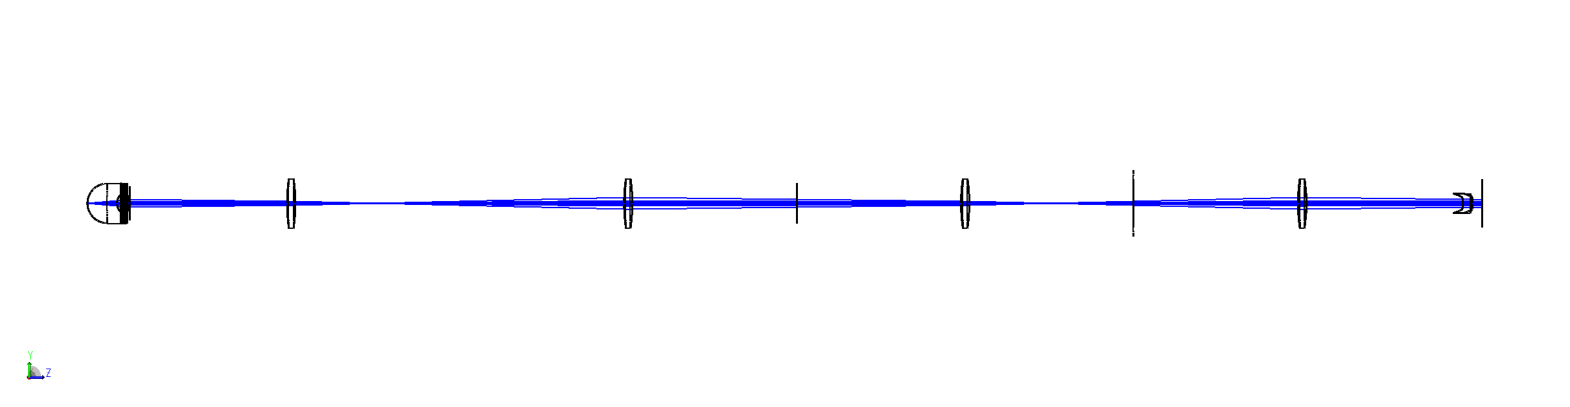

In [15]:
draw3d = zp.analyses.systemviewers.Viewer3D(
    number_of_rays=7,
    hide_x_bars=True,
    surface_line_thickness="Thick",
    rays_line_thickness="Thick",
    image_size=(2400, 600),
).run(oss)

if zos.version < (24, 1, 0):
    warn(
        "Exporting the 3D viewer data is not available for this version of OpticStudio."
    )
else:
    plt.figure(figsize=(20, 10))
    plt.imshow(draw3d.data)
    plt.axis("off")

## Analyze

Now we analyze the system using various methods.

### Zernike standard coefficients

First, we evaluate the aberrations of the system using `zp.analyses.wavefront.ZernikeStandardCoefficients`.

In [16]:
zern = zp.analyses.wavefront.ZernikeStandardCoefficients(
    sampling="64x64",
    maximum_term=37,
    wavelength=1,
    field=1,
    reference_opd_to_vertex=False,
    surface=22,
).run(oss)

In [17]:
pd.DataFrame(zern.data.coefficients.values(), index=zern.data.coefficients.keys())

,value,formula
1,-8.058524e-01,1
2,0.000000e+00,4^(1/2) (p) * COS (A)
3,0.000000e+00,4^(1/2) (p) * SIN (A)
4,-7.042877e-01,3^(1/2) (2p^2 - 1)
5,0.000000e+00,6^(1/2) (p^2) * SIN (2A)
6,0.000000e+00,6^(1/2) (p^2) * COS (2A)
7,0.000000e+00,8^(1/2) (3p^3 - 2p) * SIN (A)
8,0.000000e+00,8^(1/2) (3p^3 - 2p) * COS (A)
9,0.000000e+00,8^(1/2) (p^3) * SIN (3A)
10,0.000000e+00,8^(1/2) (p^3) * COS (3A)


### Wavefront map

We create a wavefront map using `zp.analyses.wavefront.WavefrontMap`.

In [18]:
wm = zp.analyses.wavefront.WavefrontMap(
    sampling="64x64",
    wavelength=1,
    field=1,
    surface="Image",
    show_as="Surface",
    rotation="Rotate_0",
    scale=1,
    polarization=None,
    reference_to_primary=False,
    remove_tilt=False,
    use_exit_pupil=True,
).run(oss, oncomplete="Release")

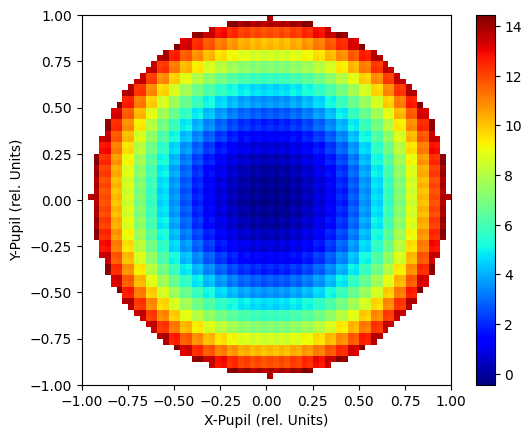

In [19]:
fig, ax = plt.subplots()
cbar = ax.imshow(
    wm.data,
    cmap="jet",
    extent=[
        wm.data.columns.values[0],
        wm.data.columns.values[-1],
        wm.data.index.values[0],
        wm.data.index.values[-1],
    ],
    origin="lower",
)

ax.set_xlabel("X-Pupil (rel. Units)")
ax.set_ylabel("Y-Pupil (rel. Units)")
_ = fig.colorbar(cbar)

### Geometric image analysis

We also perform a geometric image analysis using `zp.analyses.extendedscene.GeometricImageAnalysis`.

In [20]:
gia = zp.analyses.extendedscene.GeometricImageAnalysis(
    field_size=0,
    image_size=5,
    wavelength=1,
    field=1,
    file="CIRCLE.IMA",
    rotation=0,
    rays_x_1000=500,
    surface=25,
    show_as="CrossX",
    row_column_number="Center",
    source="Uniform",
    number_of_pixels=300,
    use_polarization=True,
    total_watts=1,
    remove_vignetting_factors=False,
    scatter_rays=False,
    parity="Even",
    delete_vignetted=False,
    use_pixel_interpolation=False,
    reference="Vertex",
).run(oss, oncomplete="Release")

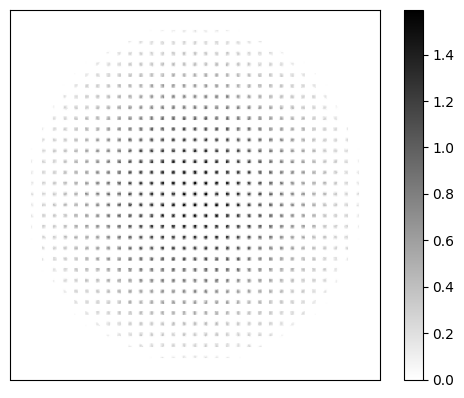

In [21]:
fig, ax = plt.subplots()
cbar = ax.imshow(
    gia.data,
    cmap="gray_r",
    extent=[
        gia.data.columns.values[0],
        gia.data.columns.values[-1],
        gia.data.index.values[0],
        gia.data.index.values[-1],
    ],
    origin="lower",
)

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

_ = fig.colorbar(cbar)

Text(0, 0.5, 'Irradiance Watts/Millimeters squared')

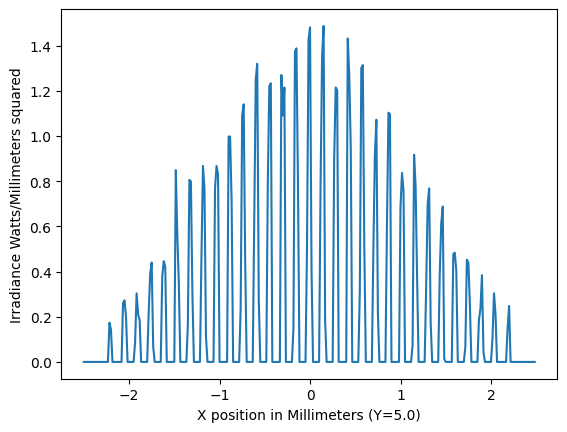

In [22]:
fig, ax = plt.subplots()
data = gia.data.iloc[150]
cbar = ax.plot(
    data,
)
ax.set_xlabel(f"X position in Millimeters (Y={gia.data.index[150]})")
ax.set_ylabel("Irradiance Watts/Millimeters squared")

## Physical Optics Propagation

Finally, we perform a Physical Optics Propagation analysis using `zp.analyses.physicaloptics.PhysicalOpticsPropagation`. 

Note that we first use a `ZOSPy` helper function `zp.analyses.physicaloptics.create_beam_parameter_dict` to create a dictionary that can be passed as `beam_parameters` to `zp.analyses.physicaloptics.PhysicalOpticsPropagation`

In [23]:
beam_params = pop = zp.analyses.physicaloptics.create_beam_parameter_dict(
    oss, beam_type="TopHat"
)

In [24]:
beam_params

{'Waist X': 2.0, 'Waist Y': 2.0, 'Decenter X': 0.0, 'Decenter Y': 0.0}

In [25]:
beam_params["Waist X"] = 5.4
beam_params["Waist X"] = 5.4
beam_params["Decenter X"] = 0.0
beam_params["Decenter Y"] = 0.0

In [26]:
pop = zp.analyses.physicaloptics.PhysicalOpticsPropagation(
    start_surface=1,
    end_surface="Image",
    wavelength=1,
    field=1,
    surface_to_beam=0,
    use_polarization=False,
    separate_xy=False,
    beam_type="TopHat",
    x_sampling=512,
    y_sampling=512,
    x_width=0.112,
    y_width=0.112,
    use_total_power=True,
    use_peak_irradiance=False,
    total_power=1,
    beam_parameters=beam_params,
    show_as="CrossX",
    data_type="Irradiance",
    project="AlongBeam",
    row_or_column="Center",
    scale_type="Linear",
    zoom_in="NoZoom",
    zero_phase_level=0.001,
    compute_fiber_coupling_integral=False,
).run(oss, oncomplete="Release")

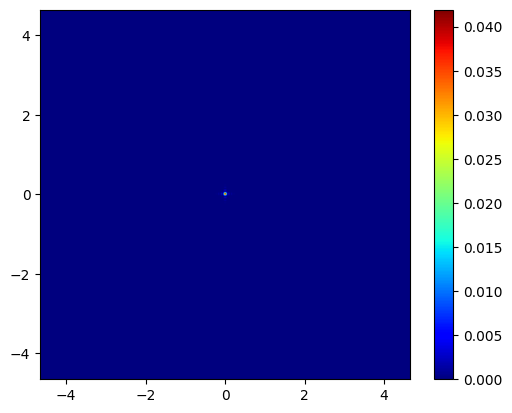

In [27]:
fig, ax = plt.subplots()
cbar = ax.imshow(
    pop.data,
    cmap="jet",
    extent=[
        pop.data.columns.values[0],
        pop.data.columns.values[-1],
        pop.data.index.values[0],
        pop.data.index.values[-1],
    ],
    origin="lower",
)

_ = fig.colorbar(cbar)

Text(0, 0.5, 'Irradiance ( Watts per sq Millimeters)')

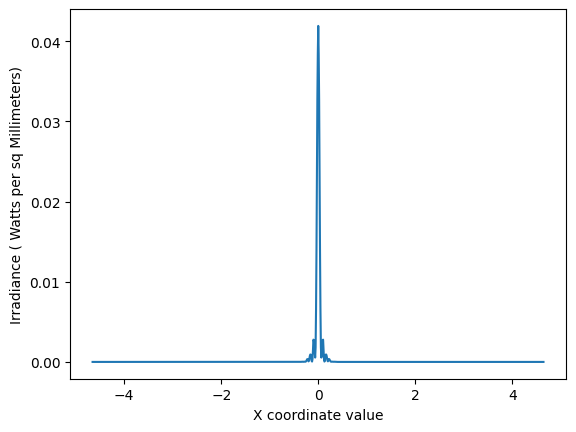

In [28]:
fig, ax = plt.subplots()
data = pop.data.iloc[512]
cbar = ax.plot(
    data,
)
ax.set_xlabel("X coordinate value")
ax.set_ylabel("Irradiance ( Watts per sq Millimeters)")